# Check and analysis gojek app sentimen

In [119]:
#dataFrame
import pandas as pd
import numpy as np

#visualization
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import seaborn as sns

#sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from sklearn.feature_extraction.text import TfidfVectorizer
#NLTK
import nltk
from nltk.corpus import stopwords

#keras
from keras.models import Sequential


from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM

from keras.callbacks import ReduceLROnPlateau, EarlyStopping
#stemmer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Word2vec
import gensim

#helper
from collections import Counter
import emoji
import re
import time
import os
import logging
import pickle
import itertools


In [120]:
#read dataset
df = pd.read_csv("datagojekcopy.csv")
print(df.shape)

(20000, 4)


In [121]:
df.head()

,userName,score,at,content
0,Robbi Eko,5,2023-03-30 14:37:38,sip... terima kasih 🙏
1,mimi cedar,5,2023-03-30 14:35:59,Bagaimana cara transfer sesama Gopay. Gopay sa...
2,Elisabeth Kiswati Ladiyo,5,2023-03-30 14:33:41,"Aman,dan cepat. Sesuai dengan ekspektasi.👍🏼👍🏼"
3,Jemmi Meliau ibanez,5,2023-03-30 14:23:25,. aplikasi yang cukup membantu
4,Boedi Arsih,5,2023-03-30 14:19:13,Cepet sampainya


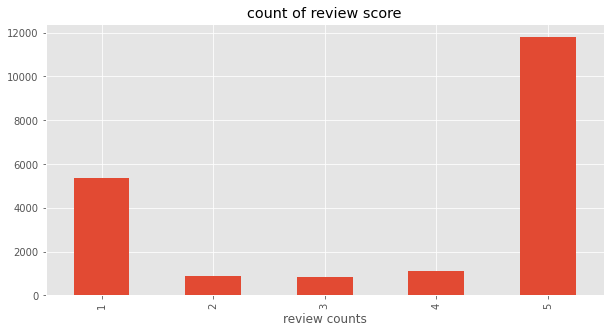

In [122]:
ax =df['score'].value_counts().sort_index().plot(
        kind = 'bar',
        title = 'count of review score',
        figsize = (10,5))
ax.set_xlabel("review counts")
plt.show()

# Cleaning singkatan kata

In [123]:
#read_dataset singkatan (data didapat dari scrapping data)
df_singkatan_scrap = pd.read_csv("singkatan_1_kata.csv")
df_singkatan_scrap.head()

,Singkatan,Kata
0,7an,tujuan
1,@,di
2,ababil,abg labil
3,abis,habis
4,acc,accord


In [124]:
#pindahkan ke dictionary
singkatan_dict_scrap = dict(zip(df_singkatan_scrap['Singkatan'], df_singkatan_scrap['Kata']))
df_singkatan_scrap.shape

(1481, 2)

In [125]:
#Membuat function mengubah singkatan dari bahasa indonesia
singkatan = {
    #a
    "apaa": "apa",
    "apaaa": "apa",
    "apaaaa": "apa",
    #"aplikasinya": "aplikasi",
    #b
    "bagu": "bagus",
    "bsa": "bisa",
    "byk": "banyak",
    #c
    #d
    "donlod"
    "dowload": "download",
    "da": "ada",
    "dll": "dan lain-lain",
    "d": "di",
    #e
    "elu": "kamu",
    #f
    #g
    "gbisa": "gak bisa",
    "gagu": "gak guna",
    "g": "gak",
    "gk": "gak",
    "gohek": "gojek",
    "goek": "gojek",
    #h
    #i
    "instal": "install",
    #j
    #k
    "knp": "kenapa",
    #l
    "loding":"loading",
    "lg": "lagi",
    "li": "beli",
    "lu": "kamu",
    #m
    "mantaap" : "mantap",
    "mantapp": "mantap",
    "mantaf": "mantap",
    #n
    "n": "dan",
    "nya" :"",
    #o
    #p
    "parahh": "parah",
    "parahhh": "parah",
    "parahhhh": "parah",
    "pedning": "pending",
    #q
    #r
    #s
    "sp": "siapa",
    "sdh": "sudah",
    "sngt": "sangat",
    #t
    "tq": "thank you",
    "tp": "tapi",
    "trs": "terus",
    "trims": "terima kasih",
    #u
    "u": "kamu",
    "udh": "udah",
    #v
    #w
    #x
    #y
    "yg": "yang",
    "sy": "saya",
    "y": "iya"
    #z
    
}

df_singkatan = pd.DataFrame(list(singkatan.items()),columns = ['singkatan','kata'])
singkatan_dict = dict(zip(df_singkatan['singkatan'], df_singkatan['kata']))

def changeAbbreviation_DF(text):
    words = text.split()
    new_words = [singkatan_dict[word] if word in singkatan_dict else word for word in words]
    return " ".join(new_words)

def changeAbbreviation_DF_scrap(text):
    words = text.split()
    new_words =[singkatan_dict_scrap[word] if word in singkatan_dict_scrap else word for word in words]
    return " ".join(new_words)

# Preprocessing text
- menghilangkan emoji
- menghilangkan symbol
- stemmer
- word_stops

In [126]:
#Prepare preprocessing text
COBA = '\.'
TEXT_CLEANING_RE = '@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+'
stop_words = set(stopwords.words("indonesian"))
retain_words = {'baik','sekali'} #menghapus stopword dari kata baik sekali
stop_words = stop_words - retain_words
factory = StemmerFactory()
stemmer = factory.create_stemmer()

### create function

In [127]:
# Remove emoji
def remove_emoji(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # simbol & piktograf
                               u"\U0001F680-\U0001F6FF"  # transport & simbol peta
                               u"\U0001F1E0-\U0001F1FF"  # bendera (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    
    return emoji_pattern.sub('',text)

In [128]:
# remove all emoji
def remove_all(text):
    sentence = remove_emoji(text)
    return sentence

#menghilangkan symbol
def remove_symbol(text):
    text = re.sub(COBA,'',str(text).strip())
    return text

#menghilangkan symbol
def remove_symbol_clean(text):
    text = re.sub(TEXT_CLEANING_RE,' ',str(text).lower().strip())
    return text

#stopwords
def stopWordsData(text, stem = False):
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [129]:
# fungsi semua preprocessing
def preprocessing_text(text):
    content = text
    content = remove_all(content)
    content = remove_symbol(content)
    content = changeAbbreviation_DF(content)
    content = changeAbbreviation_DF_scrap(content)
    content = remove_symbol_clean(content)
    content = stopWordsData(content)
    
    return content

In [130]:
#preprocessed_content melihat split data stopWors
def preprocessed_content(text):
    words = text.split()
    return words

In [131]:
## Creaete new_df
new_df = df.reset_index(drop = True)

In [132]:
new_df.loc[14436]

userName        joko suhermanto
score                         5
at          2023-01-29 14:09:17
content                   ⭐⭐⭐⭐⭐
Name: 14436, dtype: object

In [133]:
x = 0
for x in new_df.index:
    if new_df.loc[x,'content'] == "":
        x +=1
print(x)

19999


In [134]:
new_df.isnull().sum()

userName    0
score       0
at          0
content     0
dtype: int64

In [135]:
new_df.content = new_df.content.apply(lambda x : remove_all(x))

In [136]:
new_df.shape

(20000, 4)

In [137]:
#drop null content
for x in new_df.index:
    if df.loc[x,'content'] == "":
        new_df.drop(x, inplace = True)
df.shape

(20000, 4)

In [138]:
y = 0
for i in new_df.index:
    try:
        if new_df.loc[i, 'content'] == "":
            new_df.drop(i, inplace=True)
            y += 1
    except KeyError:
        continue
print(y)
new_df.shape

278


(19722, 4)

In [139]:
new_df['[preprocessed_content]'] = new_df['content'].apply(lambda x: preprocessed_content(x))

In [140]:
new_df.content = new_df.content.apply(lambda x: preprocessing_text(x))

In [141]:
new_df.head()

,userName,score,at,content,[preprocessed_content]
0,Robbi Eko,5,2023-03-30 14:37:38,ok terima kasih,"[sip..., terima, kasih]"
1,mimi cedar,5,2023-03-30 14:35:59,transfer gopay gopay transfer gopay,"[Bagaimana, cara, transfer, sesama, Gopay., Go..."
2,Elisabeth Kiswati Ladiyo,5,2023-03-30 14:33:41,aman cepat sesuai ekspektasi,"[Aman,dan, cepat., Sesuai, dengan, ekspektasi.]"
3,Jemmi Meliau ibanez,5,2023-03-30 14:23:25,aplikasi membantu,"[., aplikasi, yang, cukup, membantu]"
4,Boedi Arsih,5,2023-03-30 14:19:13,cepet sampainya,"[Cepet, sampainya]"


In [142]:
#drop kembali karena melakukan process stopwords yang kata-katanya tidak diketahui
y = 0
for i in new_df.index:
    try:
        if new_df.loc[i, 'content'] == "":
            new_df.drop(i, inplace=True)
            y += 1
    except KeyError:
        continue
print(y)
new_df.shape

113


(19609, 5)

In [143]:
new_df['[preprocessed_content]'] = new_df['content'].apply(lambda x: preprocessed_content(x))

In [144]:
#drop kembali karena melakukan process stopwords yang kata-katanya tidak diketahui
y = 0
for i in new_df.index:
    try:
        if new_df.loc[i, 'content'] == "":
            new_df.drop(i, inplace=True)
            y += 1
    except KeyError:
        continue
print(y)
new_df.shape

0


(19609, 5)